# Ideas
- Sparcity of order book
- Trade volume
- Bollinger Quotient {(x - avg(x)) / stddev(x)}

# Inputs
- Bid Volume
- Ask Volume
- B&A Spread
- Bollinger Quotient Transformed

# Output
- Real StdDev - StdDev of previous data

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
plt.rcParams['figure.figsize'] = [12, 8]

Book = pd.read_parquet('DataSet/book_train.parquet/stock_id=0/c439ef22282f412ba39e9137a3fdabac.parquet')
Trade = pd.read_parquet('DataSet/trade_train.parquet/stock_id=0/ef805fd82ff54fadb363094e3b122ab9.parquet')
Ans = pd.read_csv('DataSet/train.csv')

In [23]:
log_return = lambda list_stock_prices: np.log(list_stock_prices).diff() 
realized_volatility = lambda series_log_return: np.sqrt(np.sum(series_log_return**2))

Book['wap'] = (Book['bid_price1'] * Book['ask_size1'] + Book['ask_price1'] * Book['bid_size1']) / (Book['bid_size1']+ Book['ask_size1'])
Book.loc[:,'log_return'] = log_return(Book['wap'])
Book = Book[~Book['log_return'].isnull()]
Book = Book[Book['time_id'] == 11]
realized_vol = realized_volatility(Book['log_return'])
print(f'Realized volatility for stock_id 0 on time_id 5 is {realized_vol}')

Realized volatility for stock_id 0 on time_id 5 is 0.00396631814592512


In [26]:
import os
import glob
list_order_book_file_train = glob.glob('DataSet/book_train.parquet/*')

def realized_volatility_per_time_id(file_path, prediction_column_name):
    df_book_data = pd.read_parquet(file_path)
    df_book_data['wap'] =(df_book_data['bid_price1'] * df_book_data['ask_size1']+df_book_data['ask_price1'] * df_book_data['bid_size1'])  / (
                                      df_book_data['bid_size1']+ df_book_data[
                                  'ask_size1'])
    df_book_data['log_return'] = df_book_data.groupby(['time_id'])['wap'].apply(log_return)
    df_book_data = df_book_data[~df_book_data['log_return'].isnull()]
    df_realized_vol_per_stock =  pd.DataFrame(df_book_data.groupby(['time_id'])['log_return'].agg(realized_volatility)).reset_index()
    df_realized_vol_per_stock = df_realized_vol_per_stock.rename(columns = {'log_return':prediction_column_name})
    stock_id = file_path.split('=')[1]
    df_realized_vol_per_stock['row_id'] = df_realized_vol_per_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
    return df_realized_vol_per_stock[['row_id',prediction_column_name]]

def past_realized_volatility_per_stock(list_file,prediction_column_name):
    df_past_realized = pd.DataFrame()
    for file in list_file:
        df_past_realized = pd.concat([df_past_realized,
                                     realized_volatility_per_time_id(file,prediction_column_name)])
    return df_past_realized
df_past_realized_train = past_realized_volatility_per_stock(list_file=list_order_book_file_train,
                                                           prediction_column_name='pred')
train = pd.read_csv('DataSet/train.csv')
train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
train = train[['row_id','target']]
df_joined = train.merge(df_past_realized_train[['row_id','pred']], on = ['row_id'], how = 'left')

from sklearn.metrics import r2_score
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))
RMSPE = round(rmspe(y_true = df_joined['target'], y_pred = df_joined['pred']),3)
print(f'Performance of the naive prediction RMSPE: {RMSPE}')

list_order_book_file_test = glob.glob('DataSet/book_test.parquet/*')
df_naive_pred_test = past_realized_volatility_per_stock(list_file=list_order_book_file_test,
                                                           prediction_column_name='target')
df_naive_pred_test.to_csv('submission.csv',index = False)

ModuleNotFoundError: No module named 'sklearn'

(3, 3, 1) (3, 1)
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_46 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
Test results - Loss: 0.0012873737141489983%


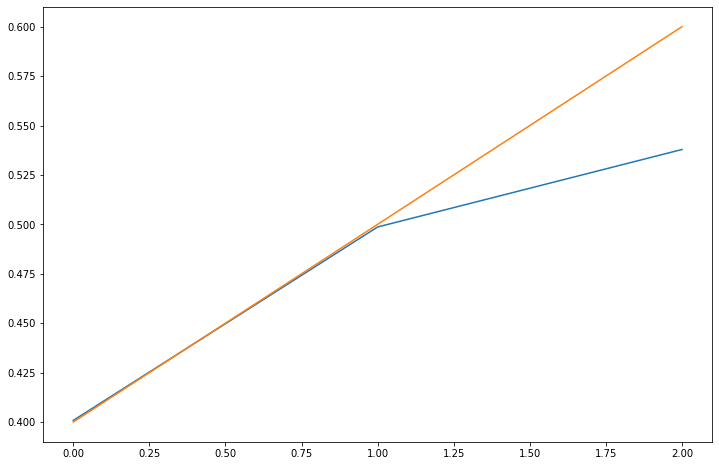

In [52]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Layer
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

tf.compat.v1.disable_eager_execution()
TimeDuration = 

inputs = np.asarray([
    [[1], [2], [3]],
    [[2], [3], [4]],
    [[3], [4], [5]],
])
outputs = np.asarray([
    [0.4],
    [0.5],
    [0.6]
])
print(inputs.shape, outputs.shape)

model = Sequential()
model.add(LSTM(1, input_shape=(3,1)))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer=Adam(), 
    loss=MeanSquaredError()
)
model.summary()

history = model.fit(
    inputs, outputs, 
    epochs=1500, verbose=False,
    validation_split=0.1
)

loss = model.evaluate(inputs, outputs)
print(f'Test results - Loss: {loss}%')

predict = model.predict(inputs)
plt.plot(predict)
plt.plot(outputs)
plt.show()